# **Introdução**

A empresa *ModaViva*, possui uma loja física e um e-commerce em forte expansão. No ano de 2011 tiveram um aumento de custo de aquisição de clientes em 35%, enquanto sua taxa de retenção caiu drásticamente. Eles não sabem quais clientes são amais valiosos a longo prazo e estão perdendo clientes para a concorrência.

Nisso foi contratado nossos serviços para a realização de segmentação de clientes, modelo de predição de churn e um motor de recomendação simples. Precisamos saber o comportamento de nossos dados e ver quais medidas tomar para a relização de nossos modelos. Com isso focaremos neste notebook uma análise exploratória e estatística de nossos dados e descobrir importantes *insights.

Para esse dia utilizaremos as seguintes bibliotecas:

- Pandas
- Matplotlib
- Seaborn
- Numpy
- Statsmodels
- Scipy

As 3 primeiras para manipulação e visualização de dados, a Numpy para operações matemáticas e as duas últimas para análise estatística.

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

O tratamento de nossos dados foi feito no arquivo **Tratamento**

In [296]:
df_churns = pd.read_csv('./Dataset/Tratado/clientes_churns.csv')
df_faturamento = pd.read_csv('./Dataset/Tratado/faturamento.csv')

df_churns.head()

,CustomerID,GastoTotal,GastoMensal,GastoMedio,TaxaDevolucao,MediaDiasCompra,TempoUltimoDiaCompra,PossivelChurn,Churn
0,12346,0.00,0.00,0.00,1.0,0,325,1,1
1,12347,4310.00,359.17,615.71,0.0,53,2,0,0
2,12348,1797.24,149.77,449.31,0.0,71,75,1,0
3,12349,1757.55,146.46,1757.55,0.0,0,18,1,0
4,12350,334.40,27.87,334.40,0.0,0,310,1,1


In [297]:
df_faturamento.head()

,Quantity,InvoiceDate,UnitPrice
0,6,2010-12-01,2.55
1,6,2010-12-01,3.39
2,8,2010-12-01,2.75
3,6,2010-12-01,3.39
4,6,2010-12-01,3.39


## **Análise Exploratória**

Antes de formular quaisquer hipóteses sobre nossos dados, é bom que saibamos como foi o ano de 2011 para a empresa, dessa forma é bom saber as vendas totais durante o ano. Começaremos então plotando um gráfico de linha para descobrir como foram as vendas mês a mês.

In [298]:
df_faturamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536641 entries, 0 to 536640
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     536641 non-null  int64  
 1   InvoiceDate  536641 non-null  object 
 2   UnitPrice    536641 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.3+ MB


In [299]:
vendas_mensal = df_faturamento.copy()
vendas_mensal['InvoiceDate'] = pd.to_datetime(vendas_mensal['InvoiceDate'])

vendas_mensal['AnoMes'] = vendas_mensal['InvoiceDate'].dt.strftime('%Y-%m')
vendas_mensal = vendas_mensal.drop('InvoiceDate', axis=1)

vendas_mensal['Total'] = vendas_mensal['UnitPrice'] * vendas_mensal['Quantity']
vendas_mensal = vendas_mensal.drop(['UnitPrice', 'Quantity'], axis=1)

vendas_mensal.head()

,AnoMes,Total
0,2010-12,15.30
1,2010-12,20.34
2,2010-12,22.00
3,2010-12,20.34
4,2010-12,20.34


In [300]:
vendas_mensal = round(vendas_mensal.groupby('AnoMes').sum(),2)
vendas_mensal = vendas_mensal.reset_index()

vendas_mensal.head()

,AnoMes,Total
0,2010-12,746723.61
1,2011-01,558448.56
2,2011-02,497026.41
3,2011-03,682013.98
4,2011-04,492367.84


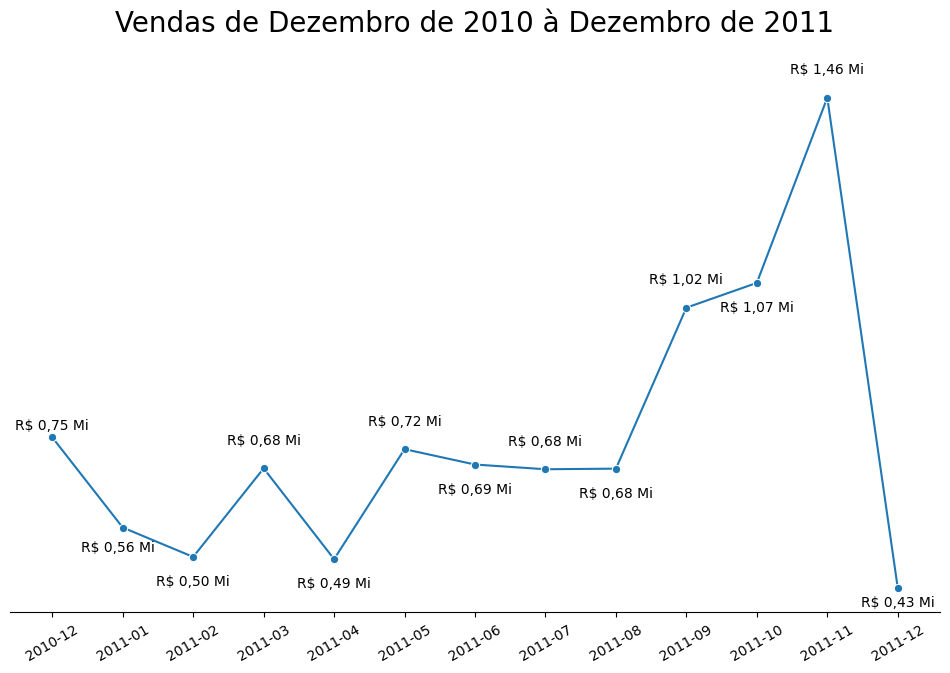

In [301]:
fig, ax = plt.subplots(figsize=(12,7))

ax = sns.lineplot(vendas_mensal, x='AnoMes', y='Total', marker='o')
ax.set_title('Vendas de Dezembro de 2010 à Dezembro de 2011', fontsize=20, pad=30)

ax.set_xlabel('')

ax.set_ylabel('')
ax.set_yticks(ticks=[])

plt.xticks(rotation=30)

for posicao, quantidade in enumerate(vendas_mensal['Total']):
    valor = f'R$ {quantidade/1000000:.2f} Mi'.replace('.',',')
    if posicao <= 1:
        if posicao == 0:
            ax.text(posicao, quantidade+40000, valor, ha='center', va='top')
        else:
            ax.text(posicao+0.45, quantidade-50000, valor, ha='right')
    elif quantidade == 432701.06:
        ax.text(posicao, quantidade-40000, valor, ha='center')
    elif posicao > 1& posicao % 2 == 0:
        ax.text(posicao, quantidade-60000, valor, ha='center')
    else:
        ax.text(posicao, quantidade+50000, valor, ha='center')

sns.despine(left=True)

Vemos então que 2011 foi um ano com muitas vendas, sendo seu pico o mês de novembro com mais de 1,46 milhão de reais em valor bruto, mas tendo sua maior queda logo no mês seguinte. Mas mesmo que em maioria os resultados pareçam satisfátórios, estamos lidando em um ano onde a empresa investiu muito em marketing e cupons de desconto.

Vamos verificar agora qual a proporção de clientes churn do ano de 2011, utilizando um gráfico de barras para comparar isso e um gráfico de pizza para ver as porcentagens.

In [302]:
churn = df_churns[['Churn']].copy()
churn['Valores'] = 1

churn = churn.groupby('Churn').count()
churn['Normalizado'] =  round((churn['Valores'] /np.sum(churn['Valores']))*100, 0)

churn

,Valores,Normalizado
Churn,,
0,2432,56.0
1,1940,44.0


/tmp/ipykernel_8646/1946066595.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(churn, x=churn.index, y='Valores', palette=['#6266F5', '#F56863'], ax=axs[0])
/tmp/ipykernel_8646/1946066595.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].xaxis.set_ticklabels(['Não Churn', 'Churn'], fontsize=15)


Text(0.5, 1.0, 'Porcentagem')

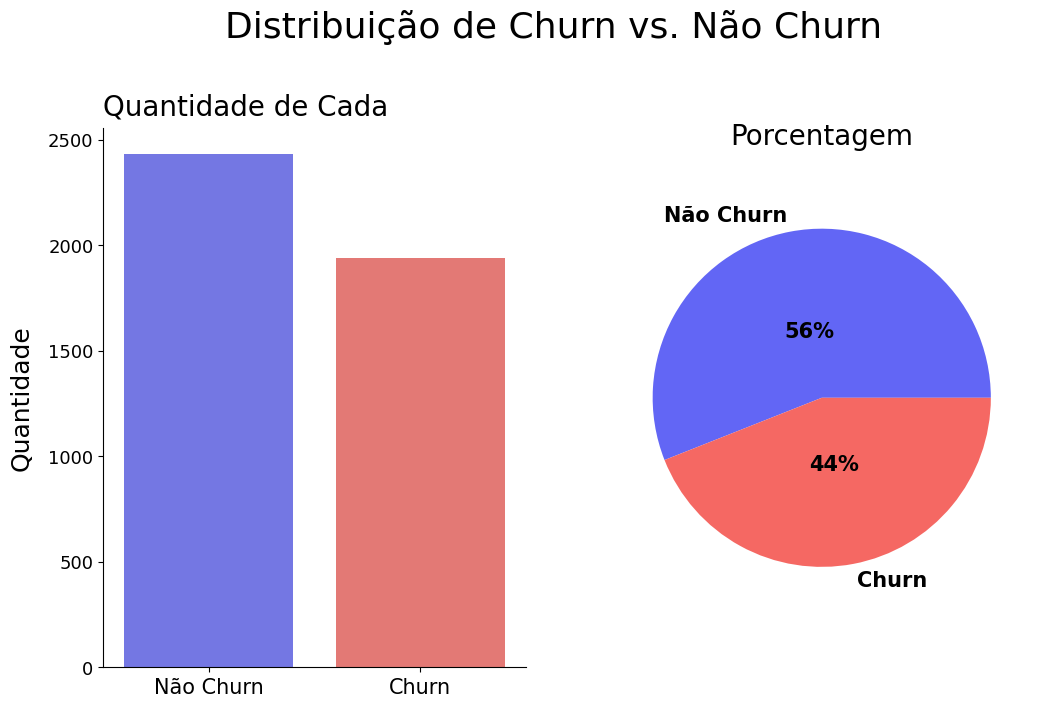

In [303]:
fig, axs = plt.subplots(1, 2, figsize=(12,7))
plt.suptitle('Distribuição de Churn vs. Não Churn', fontsize=26, y=1.05, ha='center')

sns.barplot(churn, x=churn.index, y='Valores', palette=['#6266F5', '#F56863'], ax=axs[0])
axs[0].set_title('Quantidade de Cada', fontsize=20, pad=10, loc='left')

axs[0].set_xlabel('')
axs[0].xaxis.set_ticklabels(['Não Churn', 'Churn'], fontsize=15)

axs[0].set_ylabel('Quantidade', fontsize=18, labelpad=10)
axs[0].yaxis.set_tick_params(labelsize=13)
sns.despine()

axs[1].pie(churn['Normalizado'], labels=['Não Churn', 'Churn'], colors=['#6266F5', '#F56863'], autopct="%.0f%%", pctdistance=0.4, textprops={"size": 15, "fontweight":"bold"})
axs[1].set_title('Porcentagem', fontsize=20, pad=30, ha='center')



Apesar de resultados razoáveis acima, vemos agora que a loja está enfrentando um grande problema com clientes churn's. Nosso gráfico descreve exatamente o problema principal descrito por nossa loja, no ano de 2011 eles aumentaram a quantidade de clientes por grandes promoções e marketing, mas isso não reteve os clientes.

Vamos analisar por último esse comportamento e ver a cada quantos dias os clientes efetuavam uma compra na loja utilizando um histograma, mas para esse caso vamos separar em dois, para pessoas que compram a cada 30 dias no máximo e para pessoas que compram depois de mais de 30 dias.

In [304]:
ate_30_dias = df_churns.query("MediaDiasCompra <= 30").copy()
depois_30_dias = df_churns.query("MediaDiasCompra > 30").copy()

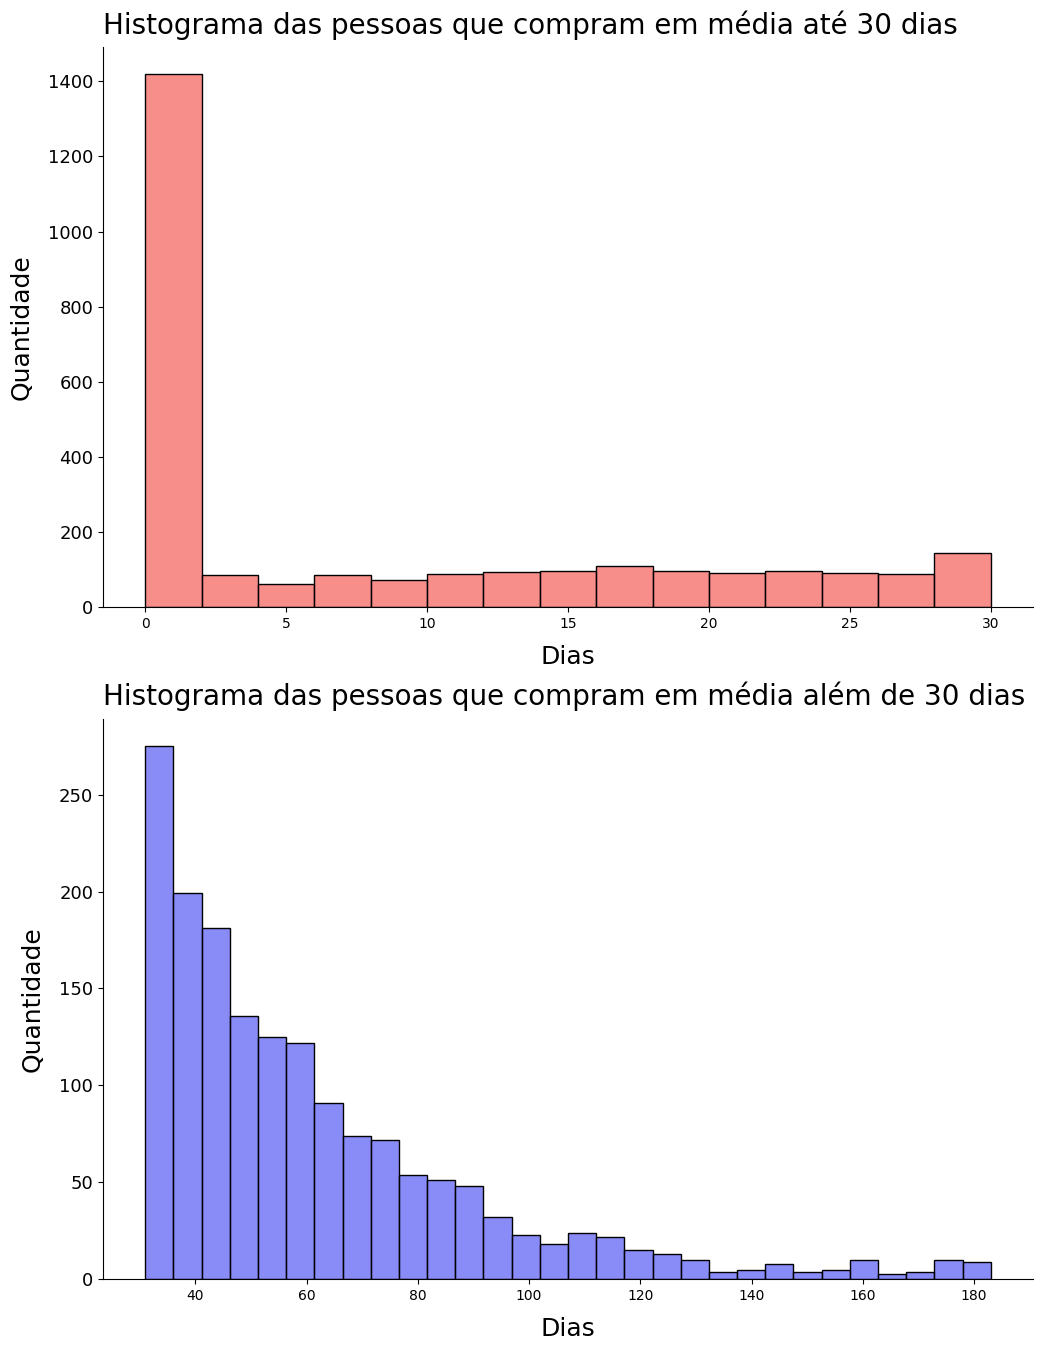

In [305]:
fig, axs = plt.subplots(2, 1, figsize=(12,16))

sns.histplot(ate_30_dias, x='MediaDiasCompra', bins=15, color='#F56863', ax=axs[0])
axs[0].set_title('Histograma das pessoas que compram em média até 30 dias', fontsize=20, pad=10, loc='left')

axs[0].set_xlabel('Dias', fontsize=18, labelpad=10)

axs[0].set_ylabel('Quantidade', fontsize=18, labelpad=10)
axs[0].yaxis.set_tick_params(labelsize=13)

sns.histplot(depois_30_dias, x='MediaDiasCompra', bins=30, color='#6266F5', ax=axs[1])
axs[1].set_title('Histograma das pessoas que compram em média além de 30 dias', fontsize=20, pad=10, loc='left')

axs[1].set_xlabel('Dias', fontsize=18, labelpad=10)

axs[1].set_ylabel('Quantidade', fontsize=18, labelpad=10)
axs[1].yaxis.set_tick_params(labelsize=13)

sns.despine()

Vemos que existe uma grande quantidade de pessoas que compram em média a cada 0 dias, isso é muito estranho, já que estariamos considerando que todo mundo comprou no último dia que tivemos registro o que isso é um absurdo, além do mais temos valores que chegam até 1400 clientes. Vemos então que isso significa que muitas pessoas só comprarm apenas uma vez, vamos analisar outro gráfico historgrama, analisando o último dia de compra, para ver se esse mesmo comportamento ocorre, pois tudo indica que isso é um grande alarme para os dados.

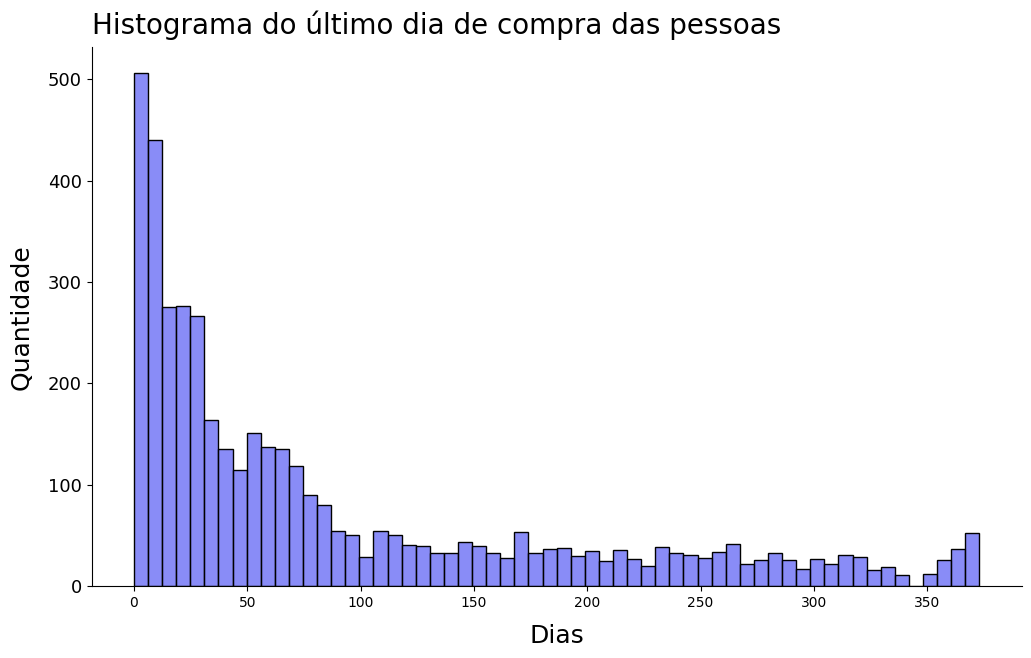

In [306]:
fig, ax= plt.subplots(figsize=(12,7))

ax = sns.histplot(df_churns, x='TempoUltimoDiaCompra', bins=60, color='#6266F5')
ax.set_title('Histograma do último dia de compra das pessoas', fontsize=20, pad=10, loc='left')

ax.set_xlabel('Dias', fontsize=18, labelpad=10)

ax.set_ylabel('Quantidade', fontsize=18, labelpad=10)
ax.yaxis.set_tick_params(labelsize=13)

sns.despine()


E por esse gráfico ao menos temos pessoas compram sim no último dia, porém ainda sim apenas 500 pessoas compraram no último dia, o que temos em torno de 900 pessoas que compraram a penas uma vez pelo gráfico anterior.

Vemos que precisamos formular hipóteses para nossos dados e ver se esse é um comportamento normal dos dados, ou se realmente isso foi um grande fator nesse ano.

## **Teste de Hipótese**

Para nossas hipótese, requeriamos dados importantes do diretor da loja que nos contratou sobre o ano de 2010 que não conseguimos ter devido os dados apenas conterem o ano de 2011. Dessa forma segue, dos dados de 2010, que as vendas brutas mensais são:

- Jan - 555.000	
- Fev - 441.000
- Mar - 580.000
- Abr - 465.000
- Mai - 595.000
- Jun - 545.000
- Jul - 525.000
- Ago - 600.000
- Set - 750.000
- Out - 870.000
- Nov - 1.150.000
- Dez - 748.000

Pedimos também os *churn's* de 2010 para podemos compararmos com os *churn's* de 2011, para avaliarmos se houve de fato uma grande diferença, com resultados do tipo 948 clientes totais, com 762 clientes fiéis e 186 clientes churn.

Com todos esses dados, podemos finalmente realizar nossas hipóteses, vamos considerar com base na realidade da loja.

- Hipótese 1: Houve uma difrença nas vendas comparado a 2010;

- Hipótese 2: A retenção de clientes diminuiu em 2011;

- Hipótese 3: Clientes que deram churn tinham um intervalo entre compras significativamente maior antes de sumirem.

### **Hipótese 1: Houve uma difrença nas vendas comparado a 2010**

A partir agora estaremos utilizando análise estatística para ver se nossas suposições estão de acordo com os gráficos de antes. Par isso estaremos dividindo nossas hipóteses em duas partes H0 (Hipótese nula) e H1 (Hipótese alternativa) a que queremos provar.

Nesse teste avaliaremos utilizando o p-valor para nos dizer se tivemos uma mudança em seus valores. O p-valor nos dirá qual a probabilidade de encontrarmos tais valores para o que tivemos supondo H0 sendo verdadeiro, para isso utilizaremos um intervalo de confiança de 95% para termos a certeza que a probabilidade encontrada não foi só um evento extremo para nossos dados, ou seja, se o p-valor tiver uma probabilidade menor que 5%, consideraremos um evento extremo e descartamos H0.

#### H0: Não houve uma difrença nas vendas comparado a 2010
#### H1: Houve uma difrença nas vendas comparado a 2010

In [307]:
vendas_2010 = (555000.00, 441000.00, 580000.00, 465000.00, 595000.00, 545000.00, 525000.00, 600000.00, 750000.00, 870000.00, 1150000.00, 748000.00)
vendas_2011 = vendas_mensal['Total'].copy().to_list()

Para essa avaliação utilizaremos o teste U de Mann-Whitney para compararmos a diferença de valores entre os meses de cada ano. Além do mais, esse teste é robusto para essa ocasião, pois estamos testando para um cenário onde 2010 tivemos 948 clientes que faziam compras na loja, já para 2011 houveram mais de 4 mil clientes na loja o que nos indica uma independência nos dados de 2010 em relação à 2011, e é para isso que o teste serve.

In [308]:
from scipy.stats import mannwhitneyu

stat, p_valor = mannwhitneyu(vendas_2011, vendas_2010, alternative="two-sided")

print(f"P-Valor: {(p_valor*100):.2f}")

P-Valor: 49.66


Vemos então que nosso P-valor foi aproximadamente 50%, ou seja, não descartamos a hipótese nula (H0). Vemos que apesar do boom clientes que a loja recebeu, a estratégia de capitação de clientes não necessariamente envolveu uma maior receita para a loja, talvez deve-se realmente focar o marketing anterior focado em clientes fiéis o que manteria uma boa margem para anos futros.

### **Hipótese 2: A retenção de clientes diminuiu em 2011**

#### H0: Em 2011 tivemos uma retenção igual

#### H1: A retenção de clientes diminuiu em 2011

In [309]:
valores_2010 = (186, 762)
valores_2011 = (churn['Valores'][1], churn['Valores'][0])

tabela_observada = [valores_2010, valores_2011]

Para esse teste agora utilizaremos o Qui-Quadrado. o Qui-Quadrado nos permite ver se a queda na taxa de retenção foi um evento aleatório ou se existe uma dependência estatística real entre a mudança de estratégia da empresa em 2011 e o comportamento de abandono dos clientes. Além disso, o Qui-Quadrado utiliza de valores esperados para saber se qual deveria ser seu valor para que H0 seja verdadeiro.

In [310]:
from scipy.stats import chi2_contingency

chi2, p_valor, dof, esperados = chi2_contingency(tabela_observada)

print(f"P-valor: {p_valor}")
print("\n--- Tabela de Valores Esperados  ---")
print(esperados)

P-valor: 5.920336179304866e-45

--- Tabela de Valores Esperados  ---
[[ 378.84360902  569.15639098]
 [1747.15639098 2624.84360902]]


E como podemos ver pelos nosso resultados, considerando o intevalo de confiança de 95%, vemos um resultado avassalador quato ao P-Valor. Seu resultado é extremamente baixo, o que nos diz poder rejeitar H0 e ficar com H1. Dessa forma, não só a utilização de marketing pesado e disponibilidade descontos aumentou os clientes como também trouxe apenas clientes ruins que não ficaram em grande parte como compradores de longo prazo.

### **Hipótese 3: Clientes que deram churn tinham um intervalo entre compras significativamente maior antes de sumirem**

#### H0: Não houve difrença ou é menor o intervalo entre compras

#### H1: Clientes que deram churn tinham um intervalo entre compras significativamente maior antes de sumirem

In [311]:
intervalo_churn = df_churns.query("Churn == 1").copy()
invervalo_nao_churn = df_churns.query("Churn == 0").copy()

Para esse último teste, vamos comparar as médias de dias de compra de cada tipo de cliente. Para isso utilizaremos agora um teste Z para compração entre duas médias de amostras diferentes.

In [312]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

test_churn = DescrStatsW(intervalo_churn['MediaDiasCompra'].sample(1000, random_state=13).to_list())
test_nao_churn = DescrStatsW(invervalo_nao_churn['MediaDiasCompra'].sample(1000, random_state=13).to_list())

teste = CompareMeans(test_churn, test_nao_churn)

z, p_valor = teste.ztest_ind(alternative='two-sided', value=0)

print(f"P-valor: {p_valor}")

P-valor: 2.9085915616802983e-27


In [313]:
z, p_valor = teste.ztest_ind(alternative='larger', value=0)

print(f"P-valor: {p_valor}")

P-valor: 1.0


In [314]:
print(np.mean(intervalo_churn['MediaDiasCompra']))
print(np.mean(invervalo_nao_churn['MediaDiasCompra']))

19.950515463917526
34.752878289473685


Com esse resultado tivemos nosso maior *insight* até agora, com o resultado do P-valor não podemos descaratar H0. Vemos que os clientes que deram churn tem, em média, uma média de compras relativamente menor que pessoas que não deram churn, o que é muito estranho.

Esse resultado não nos satisfaz, vamos realizar duas últimas hipóteses sobre nossos dados. Para descobrir mais sobre esses dados nosso quarta hipótese é a seguinte: "A maioria dos clientes churn's tiveram muitos problemas com devolução", já que as pessoas que são churn's são pessoas com muitas devoluções ou que não compram a mais de 90 dias. Para a nossa quinta hipótese ela vai ser: "Clientes que deram churn e não tiveram problemas com devolução tinham um intervalo entre compras significativamente maior antes de sumirem"

Com isso podemos saber se a causa dos churns foi por algum motivo que o levou a devolver uma compra ou se ele não quis saber da loja mesmo.

### **Hipótese 4: A maioria dos clientes churn's tiveram muitos problemas com devolução**

Vamos analisar um gráfico de barras e fazer uma comparação entre os tipos de clientes *churn's*, assim podemos responder essa última hipótese.

In [325]:
churn_devolucao = len(df_churns.query("(Churn == 1) and (TaxaDevolucao >= 0.4)"))
churn_dias = len(df_churns.query("(Churn == 1) and (TaxaDevolucao < 0.4)"))

df_tipo_churn = pd.DataFrame([churn_devolucao, churn_dias], columns=['Valores'], index=['TipoDevolução', 'TipoDias'])

porcentagem_devolucao = round(df_tipo_churn['Valores'][0] / np.sum(df_tipo_churn['Valores'])*100, 0)
porcentagem_dias = round(df_tipo_churn['Valores'][1] / np.sum(df_tipo_churn['Valores'])*100, 0) 

df_tipo_churn['Porcentagem'] = [porcentagem_devolucao, porcentagem_dias]
df_tipo_churn

/tmp/ipykernel_8646/2813028704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  porcentagem_devolucao = round(df_tipo_churn['Valores'][0] / np.sum(df_tipo_churn['Valores'])*100, 0)
/tmp/ipykernel_8646/2813028704.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  porcentagem_dias = round(df_tipo_churn['Valores'][1] / np.sum(df_tipo_churn['Valores'])*100, 0)


,Valores,Porcentagem
TipoDevolução,752,39.0
TipoDias,1188,61.0


/tmp/ipykernel_8646/1817061210.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_tipo_churn, x=df_tipo_churn.index, y='Valores', palette=['#6266F5', '#F56863'], ax=axs[0])
/tmp/ipykernel_8646/1817061210.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].xaxis.set_ticklabels(['Por Devolução', 'Por Dias'], fontsize=15)


Text(0.5, 1.0, 'Porcentagem')

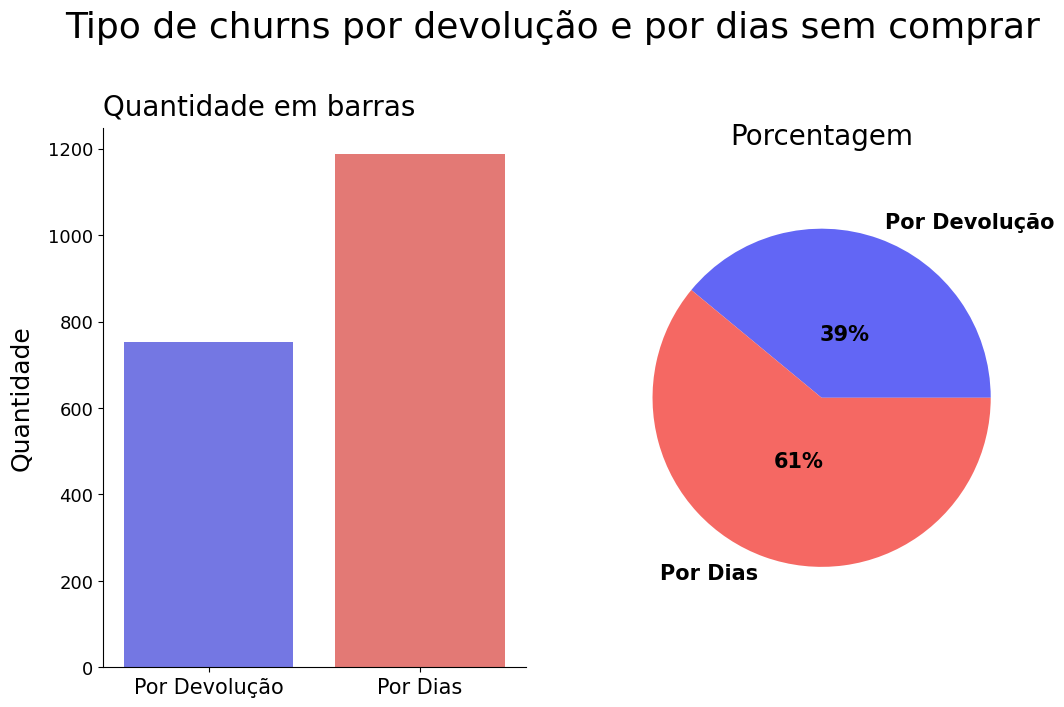

In [331]:
fig, axs = plt.subplots(1, 2, figsize=(12,7))
plt.suptitle('Tipo de churns por devolução e por dias sem comprar', fontsize=26, y=1.05, ha='center')

sns.barplot(df_tipo_churn, x=df_tipo_churn.index, y='Valores', palette=['#6266F5', '#F56863'], ax=axs[0])
axs[0].set_title('Quantidade em barras', fontsize=20, pad=10, loc='left')

axs[0].set_xlabel('')
axs[0].xaxis.set_ticklabels(['Por Devolução', 'Por Dias'], fontsize=15)

axs[0].set_ylabel('Quantidade', fontsize=18, labelpad=10)
axs[0].yaxis.set_tick_params(labelsize=13)

sns.despine()

axs[1].pie(df_tipo_churn['Porcentagem'], labels=['Por Devolução', 'Por Dias'], colors=['#6266F5', '#F56863'], 
           autopct="%.0f%%", pctdistance=0.4, textprops={"size": 15, "fontweight":"bold"})
axs[1].set_title('Porcentagem', fontsize=20, pad=30, ha='center')

E por esse gráficos, podemos ver que a maioria dos clientes são *churn's* mais por conta de simplesmente não comprarem a mais de 90 dias, porém é notável que muitos *churn's* são o que são por terem devolvido 40% ou mais de suas compras, sendo um valor de 39% de todos os *churn's*, dando ênfase a lógica para lidar com clientes com devoluções.

Vamos terminar nossas análises respondendo nossa última hipótese.

### **Hipótese 5: Clientes que deram churn e não tiveram problemas com devolução tinham um intervalo entre compras significativamente maior antes de sumirem**

#### H0: Não houve difrença ou é menor o intervalo entre compras

#### H1: Clientes que deram churn e não tiveram problemas com devolução tinham um intervalo entre compras significativamente maior antes de sumirem

In [317]:
intervalo_churn_sem_devolucao = intervalo_churn.query('TaxaDevolucao < 0.4').copy()

In [318]:
test_churn = DescrStatsW(intervalo_churn['MediaDiasCompra'].sample(1000, random_state=13).to_list())
test_nao_churn = DescrStatsW(invervalo_nao_churn['MediaDiasCompra'].sample(1000, random_state=13).to_list())

teste = CompareMeans(test_churn, test_nao_churn)

_ , p_valor = teste.ztest_ind(alternative='two-sided', value=0)

print(f"P-valor: {p_valor}")

P-valor: 2.9085915616802983e-27


In [319]:
_, p_valor = teste.ztest_ind(alternative='larger', value=0)

print(f"P-valor: {p_valor}")

P-valor: 1.0


In [321]:
print(np.mean(intervalo_churn_sem_devolucao['MediaDiasCompra']))
print(np.mean(invervalo_nao_churn['MediaDiasCompra']))

15.605218855218855
34.752878289473685


E como podemos ver, não houveram muitas diferenças entre a hipótese 3 e agora, apenas que clientes *churn's* por devolução compravam em média mais dias que os clientes *churn's* por não comprar a mais de 90 dias.

# **Conclusão**

Vimos então durante toda a análise que sim, nossa loja apresenta grande problemas com clientes *churn's*. Pelos gráficos vimos que apesar de resultados razoáveis de vendas ao longo de 2011, vemos que 44% de todos os clientes registrados são classificados como *churn's*, um valor expressivo para nosso loja que tinha clientes fiéis comparado ao ano de 2010. Vimos também que muitos clientes compravam em média a entre 0 a 2 dias, o que nos levou um grande susto pensando que a maioria dos clientes *churn's* eram assim por um grande taxa de devolução de suas compras, mas isso foi desmentido por nossos gráficos e do último dia de compra e da hipótese 4, o que condiz com o valor apresentado. Para nossas hipóteses, muitas delas acabaram não se confirmando, o que nos leva a pensar sobre como a campanha de marketing da loja e suas promoções estão funcionando.

Para nossos principais *insights* tivemos:

- Tivemos, aproximadamente, 2400 clientes fiéis e 1900 *churn's* nos dados de 2011, equivalendo 56% e 44% do total respectivamente;

- Muitos clientes compram, em média a cada 0, 1 ou 2 dias, com sua maioria comprando em 0 dias, mas com estes sendo clientes fiéis que compram no último dia e clientes *churn's* por devolução;

- As vendas de 2010 não diferenciam tanto das vendas de 2011, ou seja, o marketing não deu certo;

- A retenção de clientes diminuiu em 2011;

- A média dos dias de compra para pessoas fiéis é maior do que os *churn's*

- 39% dos *churn's* tiveram problemas com devolução, enquanto 61% foram por não comprarem a mais de 90 dias.

Com tudo isso, sugerimos ao nosso contratante que volte a estratégia de 2010 com base nas informações passadas e pelos resultados e *insights* que obtivemos. Como foi esclarecido em perguntas ao cliente, 2011 foi um ano onde a loja tentou arrecadar muitos clientes por marketing e promoção, gastando 35% a mais comparado ao ano de 2010, e como bem previu acarretou na lotação de sua loja, mas isso não significou na permanência de seus clientes e sim no afastamento dos clientes mais fiéis, onde em 2010 948 clientes geravam um grande lucro para a loja, 2011 não conseguiu superar suficientemente para justificar as ações tomadas. Com isso a estrátégia tomada em 2010 segue sendo a melhor e o caminho certo para um crescimento saudável da empresa e a retenção de clientes fiéis todos os meses para sua loja.